In [13]:
import os
os.chdir("..")

In [2]:
import pandas as pd

In [25]:
from tqdm import tqdm

In [3]:
data = pd.read_csv("data/reviews_paris_hotels_cleaned.csv")
data.head(3)

,listing_name,listing_score,username,review_score,review_title,review,cleaned_review
0,Le Bristol Paris,5.0,Traveldiarist,5.0,Still excellent—even during the pandemic,Le Bristol was just perfect during my trip to ...,Le Bristol was just perfect during my trip to ...
1,Le Bristol Paris,5.0,EdgeyP,5.0,Beautiful romantic get away,"Beautiful hotel and grounds, attentive staff s...",Beautiful hotel and grounds attentive staff sh...
2,Le Bristol Paris,5.0,Califorays,5.0,Le Bristol Hotel: this is what perfection look...,Le Bristol hotel receives so much praise that ...,Le Bristol hotel receives so much praise that ...


In [15]:
data = data[data["cleaned_review"].notna()]

In [14]:
# Load opinion lexicon
neg_file = open("data/opinion-lexicon-English/negative_words.txt",encoding = "ISO-8859-1")
pos_file = open("data/opinion-lexicon-English/positive_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

In [47]:
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''

    sent_dict = Counter()
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                sent_dict[token.head.lemma_.lower()] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):
                        sent_dict[child.lemma_.lower()] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.lemma_.lower())
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"):
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.lemma_.lower()
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.lemma_.lower() + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

In [45]:
feature_sentiment(nlp("the staff was very friendly"))

3


Counter({'staff': 1.5})

In [5]:
def extract_sentiment_aspect(review):
    sentences = nlp(review).sents
    res = []
    for sentence in sentences:
        f = feature_sentiment(sentence)
        # don't add empty objects
        if f != {}:
            res.append(f)
    return res

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [9]:
from collections import Counter

In [16]:
data["aspect_sentiment"] = data["cleaned_review"].apply(lambda review: extract_sentiment_aspect(review))
data["aspect_sentiment"]

C:\Users\SuicV\AppData\Local\Temp\ipykernel_2748\743034188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["aspect_sentiment"] = data["cleaned_review"].apply(lambda review: extract_sentiment_aspect(review))


0      [{'experience': 1, 'cleanliness': 1, 'service'...
1      [{'ground': 1, 'man': 1, 'class': 1, 'staff': ...
2      [{'bristol hotel': 1.5, 'praise': 1.5, 'review...
3      [{'year absence': -1, 'experience': 2.5, 'pari...
4                                          [{'room': 1}]
                             ...                        
215                   [{'staff': 0, 'attentive': 3.375}]
216    [{'hotel': 1, 'hotel room': 1, 'standard': 1},...
217    [{'hotel': 1, 'room': 1}, {'floor': 1, 'room':...
218    [{'word': -1, 'tidy': 1, 'dream': 1.5, 'conven...
219                                                   []
Name: aspect_sentiment, Length: 214, dtype: object

In [ ]:
aspects_summary_ = pd.DataFrame(columns= ["aspect", "sentiment", "score"])
for id_, items in tqdm(data["aspect_sentiment"].items()):
    to_append = []
    for item in items:
        for i in item:
            if i in aspects_:
                to_add = pd.Series([i, "positive" if item[i] > 0 else "negative", item[i]], index = ["aspect", "sentiment", "score"])
                aspects_summary_ = aspects_summary_.append(to_add, ignore_index=True)                

In [32]:
grouped_aspects_summary_ = aspects_summary_.groupby(["aspect", "sentiment"]).size().reset_index(name="count").sort_values("count", ascending=False)

In [30]:
import seaborn as sns

In [41]:
sns.set_theme()

In [36]:
aspects_[0:10]

['hotel',
 'room',
 'staff',
 'location',
 'breakfast',
 'time',
 'restaurant',
 'day',
 'service',
 'night']

In [39]:
first_aspects_ = grouped_aspects_summary_.query("aspect in ['hotel','room','staff','location','breakfast','time','restaurant','day','service','night']")

<AxesSubplot:xlabel='aspect', ylabel='count'>

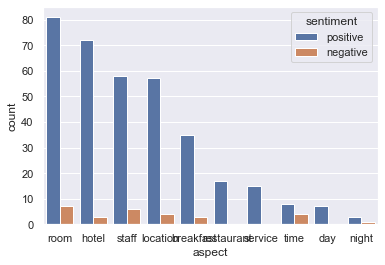

<AxesSubplot:xlabel='aspect', ylabel='count'>

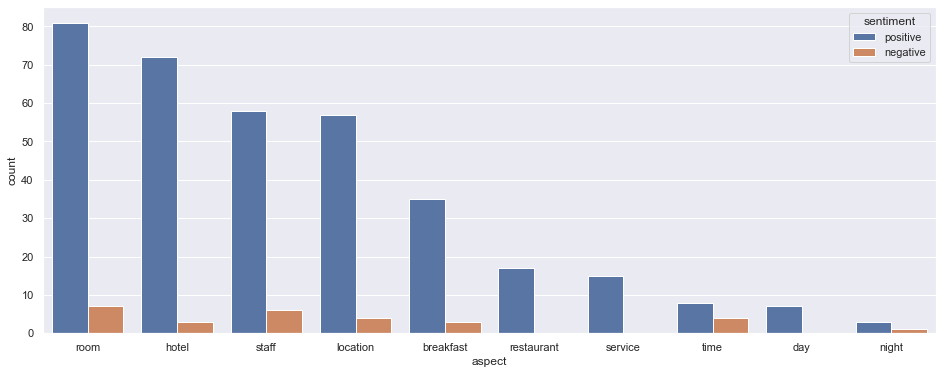

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,6))
sns.barplot(data= first_aspects_, x="aspect", y="count", hue="sentiment")

In [17]:
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor

In [21]:
aspects = ExplicitAspectExtractor(data["cleaned_review"], nlp).start(30)

In [23]:
aspects_ = list(dict(aspects).keys())

In [118]:
feature_sentiment(nlp("clean room"))

room


Counter({'room': 1})

In [48]:
feature_sentiment(nlp("the actual hotel accomodations were very luxurious and absolutely wonderful, but antumalal was too far away from the actual town of pucon."))

Counter({'hotel accomodation': 1.5})

In [49]:
feature_sentiment(nlp("i recommend this hotel as the best of the city."))

Counter({'hotel': 1})

In [52]:
"i recommend this hotel as the best of the city."
displacy.render(nlp("the wifi was good"))

In [1]:
from spacy import displacy

In [44]:
displacy.render(nlp("i liked this hotel but not the location"))

In [43]:
feature_sentiment(nlp("i liked this hotel but not location"))

3
3
kk2
3


Counter({'hotel': 1, 'location': 1})

In [132]:
displacy.render(nlp("the staff and the owner as well were professional"))

In [59]:
list(nlp("room not clean")[1].dep_)

['n', 'e', 'g']

In [110]:
"recommend" in pos

True